# Downloading the `dataset`

In [1]:
import torchvision.datasets.voc as voc

class PascalVOC_Dataset(voc.VOCDetection):

    def __init__(self, root, year='2012', image_set='train', download=False, transform=None, target_transform=None):
        
        super().__init__(
             root, 
             year=year, 
             image_set=image_set, 
             download=download, 
             transform=transform, 
             target_transform=target_transform)
    
    
    def __getitem__(self, index):
        return super().__getitem__(index)
        
    
    def __len__(self):
        return len(self.images)

# Some Wrapper Function

In [2]:
import os
import math
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score
import pandas as pd
import torchvision

In [3]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                     'cow', 'diningtable', 'dog', 'horse',
                     'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']

def encode_labels(target):
    
    ls = target['annotation']['object']
  
    j = []
    if type(ls) == dict:
        if int(ls['difficult']) == 0:
            j.append(object_categories.index(ls['name']))
  
    else:
        for i in range(len(ls)):
            if int(ls[i]['difficult']) == 0:
                j.append(object_categories.index(ls[i]['name']))
    
    k = np.zeros(len(object_categories))
    k[j] = 1
  
    return torch.from_numpy(k)

In [4]:
def get_ap_score(y_true, y_scores):

    scores = 0.0
    
    for i in range(y_true.shape[0]):
        scores += average_precision_score(y_true = y_true[i], y_score = y_scores[i])
    
    return scores

In [5]:
def plot_history(train_hist, val_hist, y_label, filename, labels=["train", "validation"]):
    """
    Plot training and validation history
    
    Args:
        train_hist: numpy array consisting of train history values (loss/ accuracy metrics)
        valid_hist: numpy array consisting of validation history values (loss/ accuracy metrics)
        y_label: label for y_axis
        filename: filename to store the resulting plot
        labels: legend for the plot
        
    Returns:
        None
    """
    # Plot loss and accuracy
    xi = [i for i in range(0, len(train_hist), 2)]
    plt.plot(train_hist, label = labels[0])
    plt.plot(val_hist, label = labels[1])
    plt.xticks(xi)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(y_label)
    plt.savefig(filename)
    plt.show()

# Downloading the `ResNet50` Model

In [6]:
import torchvision.models as models

model = models.resnet50(pretrained=True)

In [7]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Setting the GPU(`cuda`)

In [8]:
import torch 
import numpy as np 

use_cuda = torch.cuda.is_available()
np.random.seed(43)
torch.manual_seed(43)
device = torch.device("cuda" if use_cuda else "cpu")

In [9]:
device

device(type='cuda')

# Training the model

In [ ]:
#!pip install torch-summary

In [ ]:
# from torchsummary import summary
# summary(model, (3, 300,300))

In [11]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transformations = transforms.Compose([transforms.Resize((300, 300)),                                   
                                      transforms.RandomChoice([
                                          transforms.ColorJitter(brightness=(0.80, 1.20)),
                                          transforms.RandomGrayscale(p = 0.25)
                                          ]),
                                      transforms.RandomHorizontalFlip(p = 0.25),
                                      transforms.RandomRotation(25),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean = mean, std = std),
                                      ])

transformations_valid = transforms.Compose([transforms.Resize(300), 
                                            transforms.CenterCrop(300), 
                                            transforms.ToTensor(), 
                                            transforms.Normalize(mean = mean, std = std),
                                          ])

In [12]:
import os 
from torch.utils.data import DataLoader


data_dir = os.getcwd()
download_data = False
batch_size = 16 

# Create train dataloader
dataset_train = PascalVOC_Dataset(data_dir,
                                  year='2012', 
                                  image_set='train', 
                                  download=download_data, 
                                  transform=transformations,
                                  target_transform=encode_labels
                                 )


train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=4, shuffle=True)

# Create validation dataloader
dataset_valid = PascalVOC_Dataset(data_dir,
                                  year='2012', 
                                  image_set='val', 
                                  download=download_data, 
                                  transform=transformations_valid, 
                                  target_transform=encode_labels
                                 )

valid_loader = DataLoader(dataset_valid, batch_size=batch_size, num_workers=4)

In [13]:
from tqdm import tqdm
import torch
import gc
import os
import numpy as np

In [14]:
def train_model(model, device, optimizer, scheduler, train_loader, valid_loader, save_dir, model_num, epochs, log_file):
    """
    Train the DNN
    
    Args:
        model: pytorch model object
        device: cuda or cpu
        optimizer: pytorch optimizer object
        scheduler: learning rate scheduler object that wraps the optimizer
        train_dataloader: training  images dataloader
        valid_dataloader: validation images dataloader
        save_dir: Location to save model weights, plots and log_file
        epochs: number of training epochs
        log_file: text file instance to record training and validation history
        
    Returns:
        Training history and Validation history (loss and average precision)
    """
    
    tr_loss, tr_map = [], []
    val_loss, val_map = [], []
    best_val_map = 0.0
    
    # Each epoch has a training and validation phase
    for epoch in range(epochs):
        print("-------Epoch {}----------".format(epoch+1))
        log_file.write("Epoch {} >>".format(epoch+1))
        scheduler.step()
        
        for phase in ['train', 'valid']:
            running_loss = 0.0
            running_ap = 0.0
            
            criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
            m = torch.nn.Sigmoid()
            
            if phase == 'train':
                model.train(True)  # Set model to training mode
                
                for data, target in tqdm(train_loader):
                    #print(data)
                    target = target.float()
                    data, target = data.to(device), target.to(device)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    
                    output = model(data)
                    
                    loss = criterion(output, target)
                    
                    # Get metrics here
                    running_loss += loss # sum up batch loss
                    running_ap += get_ap_score(torch.Tensor.cpu(target).detach().numpy(), torch.Tensor.cpu(m(output)).detach().numpy()) 
               
                    # Backpropagate the system the determine the gradients
                    loss.backward()
                    
                    # Update the paramteres of the model
                    optimizer.step()
            
                    # clear variables
                    del data, target, output
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                    #print("loss = ", running_loss)
                    
                num_samples = float(len(train_loader.dataset))
                tr_loss_ = running_loss.item()/num_samples
                tr_map_ = running_ap/num_samples
                
                print('train_loss: {:.4f}, train_avg_precision:{:.3f}'.format(
                    tr_loss_, tr_map_))
                
                log_file.write('train_loss: {:.4f}, train_avg_precision:{:.3f}, '.format(
                    tr_loss_, tr_map_))
                
                # Append the values to global arrays
                tr_loss.append(tr_loss_), tr_map.append(tr_map_)
                        
                        
            else:
                model.train(False)  # Set model to evaluate mode
        
                # torch.no_grad is for memory savings
                with torch.no_grad():
                    for data, target in tqdm(valid_loader):
                        target = target.float()
                        data, target = data.to(device), target.to(device)
                        output = model(data)
                        
                        loss = criterion(output, target)
                        
                        running_loss += loss # sum up batch loss
                        running_ap += get_ap_score(torch.Tensor.cpu(target).detach().numpy(), torch.Tensor.cpu(m(output)).detach().numpy()) 
                        
                        del data, target, output
                        gc.collect()
                        torch.cuda.empty_cache()

                    num_samples = float(len(valid_loader.dataset))
                    val_loss_ = running_loss.item()/num_samples
                    val_map_ = running_ap/num_samples
                    
                    # Append the values to global arrays
                    val_loss.append(val_loss_), val_map.append(val_map_)
                
                    print('val_loss: {:.4f}, val_avg_precision:{:.3f}'.format(
                    val_loss_, val_map_))
                    
                    log_file.write('val_loss: {:.4f}, val_avg_precision:{:.3f}\n'.format(
                    val_loss_, val_map_))
                    
                    # Save model using val_acc
                    if val_map_ >= best_val_map:
                        best_val_map = val_map_
                        log_file.write("saving best weights...\n")
                        torch.save(model.state_dict(), os.path.join(save_dir,"model-{}.pth".format(model_num)))
                    
    return ([tr_loss, tr_map], [val_loss, val_map])

# Changing the last layer

In [15]:
import torch.optim as optim
import torch.nn as nn 

# No. of class in VOC Dataset is 20 
num_classes = 20 

#Changing the last FC layer 
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

In [17]:
model = model.to(device)
lr = [1.5e-4, 5e-2]
optimizer = optim.SGD([   
        {'params': list(model.parameters())[:-1], 'lr': lr[0], 'momentum': 0.9},
        {'params': list(model.parameters())[-1], 'lr': lr[1], 'momentum': 0.9}
        ])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 12, eta_min=0, last_epoch=-1)

num = 1
epochs = 10 
log_file = open(os.path.join(data_dir, "log-{}.txt".format(num)), "w+")

In [18]:
trn_hist, val_hist = train_model(
                                 model = model, 
                                 device = device, 
                                 optimizer = optimizer, 
                                 scheduler = scheduler, 
                                 train_loader = train_loader, 
                                 valid_loader = valid_loader, 
                                 save_dir = data_dir, 
                                 model_num = num, 
                                 epochs = epochs, 
                                 log_file = log_file
                                )

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/358 [00:00<?, ?it/s]

-------Epoch 1----------


  0%|          | 0/364 [00:00<?, ?it/s]

train_loss: 2.7666, train_avg_precision:0.783


100%|██████████| 364/364 [00:34<00:00, 10.56it/s]


val_loss: 2.7699, val_avg_precision:0.839


  0%|          | 0/358 [00:00<?, ?it/s]

-------Epoch 2----------


  0%|          | 0/364 [00:00<?, ?it/s]

train_loss: 1.9674, train_avg_precision:0.875


100%|██████████| 364/364 [00:35<00:00, 10.33it/s]


val_loss: 2.0431, val_avg_precision:0.875


  0%|          | 0/358 [00:00<?, ?it/s]

-------Epoch 3----------


  0%|          | 0/364 [00:00<?, ?it/s]

train_loss: 1.7172, train_avg_precision:0.898


100%|██████████| 364/364 [00:35<00:00, 10.19it/s]


val_loss: 1.9229, val_avg_precision:0.882


  0%|          | 0/358 [00:00<?, ?it/s]

-------Epoch 4----------


  0%|          | 0/364 [00:00<?, ?it/s]

train_loss: 1.4633, train_avg_precision:0.921


100%|██████████| 364/364 [00:34<00:00, 10.44it/s]


val_loss: 1.7747, val_avg_precision:0.901


  0%|          | 0/358 [00:00<?, ?it/s]

-------Epoch 5----------


  0%|          | 0/364 [00:00<?, ?it/s]

train_loss: 1.1502, train_avg_precision:0.950


100%|██████████| 364/364 [00:34<00:00, 10.42it/s]


val_loss: 1.6813, val_avg_precision:0.912


  0%|          | 0/358 [00:00<?, ?it/s]

-------Epoch 6----------


  0%|          | 0/364 [00:00<?, ?it/s]

train_loss: 0.9348, train_avg_precision:0.967


100%|██████████| 364/364 [00:35<00:00, 10.36it/s]


val_loss: 1.6246, val_avg_precision:0.922


  0%|          | 0/358 [00:00<?, ?it/s]

-------Epoch 7----------


  0%|          | 0/364 [00:00<?, ?it/s]

train_loss: 0.7315, train_avg_precision:0.979


100%|██████████| 364/364 [00:35<00:00, 10.13it/s]


val_loss: 1.5472, val_avg_precision:0.926


  0%|          | 0/358 [00:00<?, ?it/s]

-------Epoch 8----------


  0%|          | 0/364 [00:00<?, ?it/s]

train_loss: 0.5904, train_avg_precision:0.986


100%|██████████| 364/364 [00:34<00:00, 10.52it/s]


val_loss: 1.5954, val_avg_precision:0.927


  0%|          | 0/358 [00:00<?, ?it/s]

-------Epoch 9----------


  0%|          | 0/364 [00:00<?, ?it/s]

train_loss: 0.4849, train_avg_precision:0.991


100%|██████████| 364/364 [00:35<00:00, 10.29it/s]


val_loss: 1.5159, val_avg_precision:0.930


  0%|          | 0/358 [00:00<?, ?it/s]

-------Epoch 10----------


  0%|          | 0/364 [00:00<?, ?it/s]

train_loss: 0.4221, train_avg_precision:0.993


100%|██████████| 364/364 [00:34<00:00, 10.40it/s]


val_loss: 1.5058, val_avg_precision:0.932


In [19]:
torch.cuda.empty_cache()

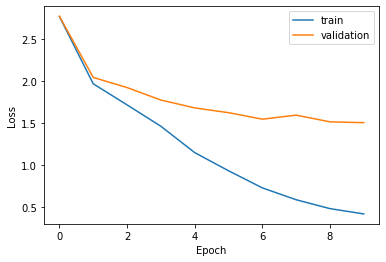

In [20]:
plot_history(trn_hist[0], val_hist[0], "Loss", os.path.join(data_dir, "loss-{}".format(num)))

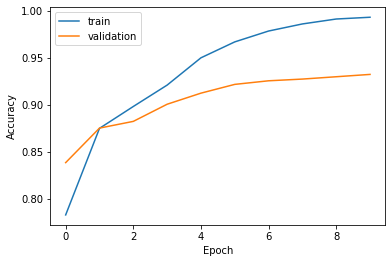

In [21]:
plot_history(trn_hist[1], val_hist[1], "Accuracy", os.path.join(data_dir, "accuracy-{}".format(num)))    

In [22]:
log_file.close()

# Final Trained Model

In [23]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Testing the model

In [24]:
model_path = os.path.join(data_dir,"model-{}.pth".format(num))

In [25]:
transform_test = transforms.Compose([
                                    transforms.RandomResizedCrop(300), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = mean, std = std),
                                    ])

dataset_test = PascalVOC_Dataset(data_dir,
                                  year='2012', 
                                  image_set='val', 
                                  download=download_data, 
                                  transform=transform_test, 
                                  target_transform=encode_labels)

In [26]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5               # de-normalize the image
    plt.figure(figsize=(batch_size, 5))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Resetting the index (224, 224, 3) from (3, 224, 224)
    plt.title(title)
    plt.show()

In [27]:
def show_batch_images(images, labels):
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[object_categories[torch.argmax(x).item()] for x in labels])

In [59]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    inputs, labels = next(iter(dataloader))
    total = labels.size(0)
    
    show_batch_images(inputs, labels)
    
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    actual_labels = [ torch.argmax(l).item() for l in labels ]
    predicted_labels = [ torch.argmax(l).item() for l in outputs ]
    
    for i, j in zip(actual_labels, predicted_labels):
        if i == j:
            correct += 1

    acc = round(100 * correct / total, 2)
    print(f"Actual Label    : {actual_labels}")
    print(f"Predicted Label : {predicted_labels}")
    
    print(f"No. of correct prediction : {correct}, out of total : {total}")
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


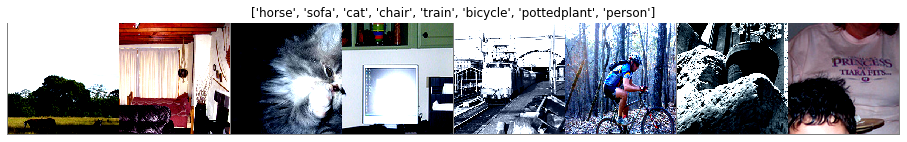

Actual Label    : [12, 17, 7, 8, 18, 1, 15, 14]
Predicted Label : [14, 17, 7, 19, 18, 1, 15, 14]
No. of correct prediction : 6, out of total : 8


In [61]:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=True)
evaluation(test_loader, model)

In [68]:
def total_evaluation(dataloader, model):
    total, correct = 0, 0
    
    for data in dataloader:
        
        inputs, labels = data
        total += labels.size(0)

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        actual_labels = [ torch.argmax(l).item() for l in labels ]
        predicted_labels = [ torch.argmax(l).item() for l in outputs ]
    
        for i, j in zip(actual_labels, predicted_labels):
            if i == j:
                correct += 1

    acc = round(100 * correct / total, 2)
    
    print(f"Accuracy on Test Data : {acc}")
    

In [69]:
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=8, shuffle=True)
total_evaluation(test_loader, model)

Accuracy on Test Data : 67.18
